<a href="https://colab.research.google.com/github/MMaggieZhou/FunModels/blob/main/GAN-Draw_Anime_Faces/model_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here we use two metrics to evaluate trained GAN models:
1. FID score: how close generated images are, to trained real images 
2. Face score: how confident that an anime face is detected from a generated image.

## Setup 

### connect to google drive
Models are saved there. It's because training model is expensive, we don't want it to go away after colab is disconnected.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
CHECKPOINT_DIR = '/content/gdrive/MyDrive/Colab Notebooks'

### Download model for face detection from github 

The github project is https://github.com/qhgz2013/anime-face-detector

1. Follow the links there and download model checkpoint, unzip and upload all files to directory '/content/gdrive/MyDrive/Colab Notebooks/anime face detector/res101_faster_rcnn_iter_60000/'
2. Run the code below, this will download the source code. We need the source code to load the model, from checkpoint. 
3. Rename 'anime-face-detector' to 'anime_face_detector' as python package/library names can't have hyphens. 


In [3]:
!git clone https://github.com/qhgz2013/anime-face-detector.git

Cloning into 'anime-face-detector'...
remote: Enumerating objects: 103, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 103 (delta 30), reused 22 (delta 22), pack-reused 62
Receiving objects: 100% (103/103), 4.36 MiB | 11.12 MiB/s, done.
Resolving deltas: 100% (40/40), done.


###Download training images 

In [4]:
DATA_DIR = '.' 


In [5]:
# a pypi package to download large file from google drive 
!gdown --id 1IGrTr308mGAaCKotpkkm8wTKlWs9Jq-p -O "{DATA_DIR}/crypko_data.zip"
!unzip -q -o "{DATA_DIR}/crypko_data.zip" -d "{DATA_DIR}/"

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1IGrTr308mGAaCKotpkkm8wTKlWs9Jq-p
To: /content/crypko_data.zip
100% 452M/452M [00:01<00:00, 226MB/s]


### Imports 

In [6]:
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds

import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import scipy

## Generative Model 


In [7]:
w_init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
gamma_initializer = tf.keras.initializers.RandomNormal(mean=1.0, stddev=0.02)

def add_dense_layer_for_noise(
    model,
    input_dim, 
    output_dim,
): 
    model.add(layers.Dense(
        units=output_dim, 
        input_shape=(input_dim,), 
        use_bias=False
    ))
    model.add(layers.BatchNormalization(
        gamma_initializer=gamma_initializer
    ))
    model.add(layers.ReLU())

# image size will be doubled 
def add_conv2d_transpose(
    model,
    num_output_filters, 
    add_batch_norm=True
):
    model.add(layers.Conv2DTranspose(
        num_output_filters, 
        5, # filter size
        strides=2, 
        padding='same', 
        use_bias=False, 
        kernel_initializer=w_init,
    ))
    if add_batch_norm:
      model.add(layers.BatchNormalization(
          gamma_initializer=gamma_initializer
      ))
      model.add(layers.ReLU())

def create_unconditional_generator(
    noise_dim,
    image_dim, # output image
):
    model = tf.keras.Sequential()
    add_dense_layer_for_noise(
        model, input_dim=noise_dim, 
        output_dim=(image_dim * 8) * (image_dim/16) * (image_dim/16)
    )

    model.add(layers.Reshape(
        (int(image_dim/16), int(image_dim/16), image_dim * 8))
    ) # image_dim/16 * image_dim/16 * filters

    add_conv2d_transpose(model, image_dim * 4) # image_dim/8 * image_dim/8 * filters
    add_conv2d_transpose(model, image_dim * 2) # image_dim/4 * image_dim/4 * filters
    add_conv2d_transpose(model, image_dim * 1) # image_dim/2 * image_dim/2 * filters

    add_conv2d_transpose(model, 3, add_batch_norm=False) # image_dim * image_dim * 3
    model.add(layers.Activation("tanh"))
    return model

### load model from checkpoint and generate images

In [8]:
# this generate images in RGB and values in [-1, 1] as float
# as numpy for simplicity, not most efficient of course
def get_samples(test_name, checkpoint_number, transformations, num_samples):
    NOISE_DIM = 100
    IMAGE_DIM = 64
    generator = create_unconditional_generator(NOISE_DIM, IMAGE_DIM)
    ckpt = tf.train.Checkpoint(
        generator=generator,
    )
    ckpt.restore(f'{CHECKPOINT_DIR}/{test_name}/checkpoints/ckpt-{checkpoint_number}').expect_partial()
    tf.random.set_seed(2022)
    test_noises = tf.random.normal([num_samples, NOISE_DIM])
    images = generator(test_noises, training=False)
    images = images.numpy()
    ret = []
    for image in images: 
        for transformation in transformations: 
            image = transformation(image)
        ret.append(image)
    return ret

## Data Loading and Transformations 



In [9]:
# transformations 
def float_to_int(image):
    return ((image + 1) * 127.5).astype(int)

def rgb_to_gbr(image):
    r,g,b = cv2.split(image)
    return cv2.merge([g,b,r])

def load_real_images(num_images, transformations): 
    images = tf.keras.utils.image_dataset_from_directory(
        f'{DATA_DIR}/faces', 
        labels=None,
        batch_size=num_images,
        shuffle=False,
        image_size=[64, 64]
    )
    normalization_layer = tf.keras.layers.Rescaling(2.0/255, offset=-1)
    images = images.map(lambda x: normalization_layer(x))
    
    batches = images.take(1)
    batches = tfds.as_numpy(batches) 
    
    ret = []
    for batch in batches:
        for image in batch:
            for transformation in transformations:
                image = transformation(image)
            ret.append(image)
        break
    return ret 

def test_gan_loading():
    images = get_samples('DCGAN/11_07_2022', 9, [float_to_int, rgb_to_gbr], 4)
    for image in images:
        cv2_imshow(image)

### Load images for evaluation 
**note: this has to run before loading anime face detector, which uses tensorflow compact, which disables eager execution, where our models written in tensorflow v2 aren't compatible.**

In [10]:
NUM_IMAGES = 360

In [11]:
 
PARAMETERS = {
    'WGAN/11_05_2022': {
        'START_INDEX': 4,
        'END_INDEX': 23,
    },
    'DCGAN/11_07_2022': {
        'START_INDEX': 1,
        'END_INDEX': 12,
    }
}
GENERATED_IMAGES = {}
for test_name, parameters in PARAMETERS.items():
    GENERATED_IMAGES[test_name] = {}
    for i in range(parameters['START_INDEX'], parameters['END_INDEX'] + 1):
        GENERATED_IMAGES[test_name][i] = get_samples(test_name, i, [], NUM_IMAGES)

real_images = load_real_images(NUM_IMAGES, [])

## FID 
Note that another option, that uses existing metric implemented by tensorflow_gan, suffers from crash due to memory usage https://github.com/tensorflow/gan/blob/master/tensorflow_gan/python/eval/inception_metrics.py 





In [12]:
INPUT_SIZE = 75 
def calculate_embeddings(inception_model, images):
    images = tf.image.resize_with_pad(
        images, 
        target_height=INPUT_SIZE, 
        target_width=INPUT_SIZE
    )
    return inception_model.predict(images)

def initiate_inception_model():
    return tf.keras.applications.InceptionV3(
        include_top=False, 
        weights='imagenet', 
        pooling='avg', 
        input_shape=(INPUT_SIZE, INPUT_SIZE, 3)
    )

def calculate_fid_score(real_embeddings, generated_embeddings):
    mu_real = np.mean(real_embeddings, axis = 0)
    mu_fake = np.mean(generated_embeddings, axis = 0)
    
    sigma_real = np.cov(real_embeddings, rowvar = False)
    sigma_fake = np.cov(generated_embeddings, rowvar = False)
    
    squared_diff = np.sum((mu_real - mu_fake) ** 2)
    
    covmean = scipy.linalg.sqrtm(sigma_real.dot(sigma_fake))
    
    if np.iscomplexobj(covmean):
        covmean = covmean.real
        
    fid_score = squared_diff + np.trace(sigma_real + sigma_fake - 2 * covmean)
    
    return fid_score

### Evaluate

**This has to run before face score calculation due to version incompatibility.**

In [13]:
evaluation_results = {}

inception_model = initiate_inception_model()
real_embeddings = calculate_embeddings(inception_model, real_images)

for model_name, generated_images_per_checkpoint in GENERATED_IMAGES.items():
    evaluation_results[model_name] = {}
    for check_point_num, generated_images in generated_images_per_checkpoint.items():
        evaluation_results[model_name][check_point_num] = {}
        # calculate fid score
        generated_embeddings = calculate_embeddings(inception_model, generated_images)
        fid_score = calculate_fid_score(real_embeddings, generated_embeddings)
        evaluation_results[model_name][check_point_num]['fid_score'] = fid_score

Found 71314 files belonging to 1 classes.
87910968/87910968 [==============================] - 3s 0us/step


## Anime Face Detector

### imports from github 

Add the downloaded source code to root system path, so that they can be imported and used in colab.
The trick:
https://medium.com/analytics-vidhya/importing-your-own-python-module-or-python-file-into-colab-3e365f0a35ec

Thoughts:
- How nice that now we can reuse both code and model in the community!
- I got back and forth on the solution in terms of how to leverage the model and finally settled with current one. Other solutions that has been considered, and the the original code uses compact tensorflow version, which uses different mechanism. To avoid digging into the code and having to deal with version dependency etc, i decided to reuse the code as much as possible, aka import the code.
    - https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/migrate/upgrade.ipynb 
    - https://www.folkstalk.com/2022/10/tf-1-compatible-colab-with-code-examples.html


In [15]:
import sys
sys.path.insert(0,'/content/anime_face_detector')
from faster_rcnn_wrapper import FasterRCNNSlim
from _tf_compat_import import compat_tensorflow as tf_compat
from nms_wrapper import NMSType, NMSWrapper

Instructions for updating:
non-resource variables are not supported in the long term


### load model for detection

In [16]:
class Detector: 
    def __init__(self):
        tf_compat.reset_default_graph()
        cfg = tf_compat.ConfigProto()
        cfg.gpu_options.allow_growth = True
        self.sess = tf_compat.Session(config=cfg)
        self.net = FasterRCNNSlim()
        self.saver = tf_compat.train.Saver()
        self.saver.restore(self.sess, '/content/gdrive/MyDrive/Colab Notebooks/anime face detector/res101_faster_rcnn_iter_60000/res101_faster_rcnn_iter_60000.ckpt')


    # image needs to be in [0,255] range and as BGR
    def detect(self, image):
        # pre-processing image for Faster-RCNN
        img_origin = image.astype(np.float32, copy=True)
        img_origin -= np.array([[[102.9801, 115.9465, 112.7717]]])

        img_shape = img_origin.shape
        img_size_min = np.min(img_shape[:2])
        img_size_max = np.max(img_shape[:2])

        img_scale = 600 / img_size_min
        if np.round(img_scale * img_size_max) > 1000:
            img_scale = 1000 / img_size_max
        img = cv2.resize(img_origin, None, None, img_scale, img_scale, cv2.INTER_LINEAR)
        img_info = np.array([img.shape[0], img.shape[1], img_scale], dtype=np.float32)
        img = np.expand_dims(img, 0)

        # test image
        _, scores, bbox_pred, rois = self.net.test_image(self.sess, img, img_info)

        # bbox transform
        boxes = rois[:, 1:] / img_scale

        boxes = boxes.astype(bbox_pred.dtype, copy=False)
        widths = boxes[:, 2] - boxes[:, 0] + 1
        heights = boxes[:, 3] - boxes[:, 1] + 1
        ctr_x = boxes[:, 0] + 0.5 * widths
        ctr_y = boxes[:, 1] + 0.5 * heights
        dx = bbox_pred[:, 0::4]
        dy = bbox_pred[:, 1::4]
        dw = bbox_pred[:, 2::4]
        dh = bbox_pred[:, 3::4]
        pred_ctr_x = dx * widths[:, np.newaxis] + ctr_x[:, np.newaxis]
        pred_ctr_y = dy * heights[:, np.newaxis] + ctr_y[:, np.newaxis]
        pred_w = np.exp(dw) * widths[:, np.newaxis]
        pred_h = np.exp(dh) * heights[:, np.newaxis]
        pred_boxes = np.zeros_like(bbox_pred, dtype=bbox_pred.dtype)
        pred_boxes[:, 0::4] = pred_ctr_x - 0.5 * pred_w
        pred_boxes[:, 1::4] = pred_ctr_y - 0.5 * pred_h
        pred_boxes[:, 2::4] = pred_ctr_x + 0.5 * pred_w
        pred_boxes[:, 3::4] = pred_ctr_y + 0.5 * pred_h
        # clipping edge
        pred_boxes[:, 0::4] = np.maximum(pred_boxes[:, 0::4], 0)
        pred_boxes[:, 1::4] = np.maximum(pred_boxes[:, 1::4], 0)
        pred_boxes[:, 2::4] = np.minimum(pred_boxes[:, 2::4], img_shape[1] - 1)
        pred_boxes[:, 3::4] = np.minimum(pred_boxes[:, 3::4], img_shape[0] - 1)
        return scores, pred_boxes

### detect a batch of images and calculate a single score

In [36]:
# images in range of [0, 255]
def forward(detector, images):
    results = []
    for idx, image in enumerate(images):
        scores, boxes = detector.detect(image)
        results.append([scores, boxes])
    return results 

# images in range of [0, 255], BGR
def process_forward_results(results, images, threshold):
    ret = []
    for i, (scores, boxes) in enumerate(results):
        boxes = boxes[:, 4:8]
        scores = scores[:, 1]
        max_score = max(scores)
        nms = NMSWrapper(NMSType.PY_NMS) # ? 
        keep = nms(np.hstack([boxes, scores[:, np.newaxis]]).astype(np.float32), 0.1)
        boxes = boxes[keep, :]
        scores = scores[keep]
        inds = np.where(scores >= threshold)[0]
        scores = scores[inds]
        boxes = boxes[inds, :]
        image = images[i]
        if (i + 1) % 100 == 0:
            for i in range(scores.shape[0]):
                x1, y1, x2, y2 = boxes[i, :].tolist()
                cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (0, 0, 255), 2)
            cv2_imshow(image)
        # returns max score AND number of faces detected 
        ret.append([max_score, 1 if scores.shape[0] > 0 else 0])
    return ret

def evaluate(images, results, threshold):
    scores = process_forward_results(results, images, threshold)
    average_max_score = np.mean([max_score for max_score, _ in scores])
    average_face_detected = np.mean([face_detected for _, face_detected in scores])
    return average_max_score, average_face_detected

### Baseline 
Run detection over anime face pictures, to establish a baseline. 
- Note that GPU provides performance boost of 60X, it's around 1 minute for 360 photos 
- The baseline score is very low(0.12588201, 0.1461111111111111).

On a hintsight, it would be more resource efficient to train a simple 0/1 classification model, instead of using the complex model that comes with bounding box. 

In [19]:
def anime_face_detector_with_real_images():
    images = load_real_images(3600, [float_to_int, rgb_to_gbr])
    detector = Detector()
    results = forward(detector, images)
    evaluate(images, results, 0.3)

### Evaluate 

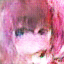

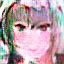

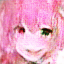

(2.6382213e-05, 0.0)


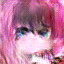

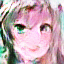

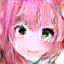

(8.261984e-05, 0.0)


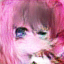

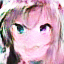

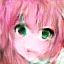

(0.0054590125, 0.005555555555555556)


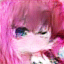

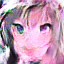

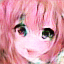

(0.0028722484, 0.002777777777777778)


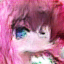

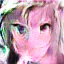

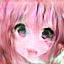

(0.0059166476, 0.008333333333333333)


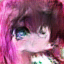

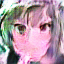

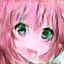

(0.0063668443, 0.005555555555555556)


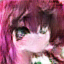

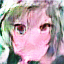

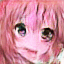

(0.0026982825, 0.002777777777777778)


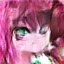

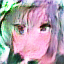

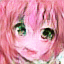

(0.000865213, 0.0)


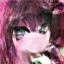

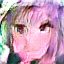

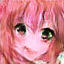

(0.0025016633, 0.002777777777777778)


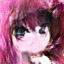

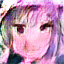

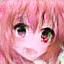

(0.004913185, 0.008333333333333333)


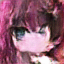

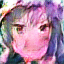

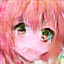

(0.0015851805, 0.002777777777777778)


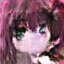

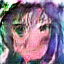

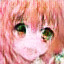

(0.0022981209, 0.002777777777777778)


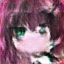

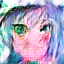

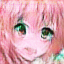

(0.003515782, 0.005555555555555556)


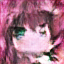

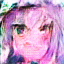

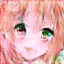

(0.0028551018, 0.002777777777777778)


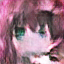

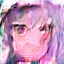

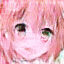

(0.0023099256, 0.002777777777777778)


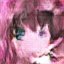

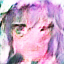

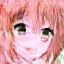

(0.004811883, 0.005555555555555556)


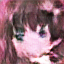

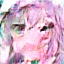

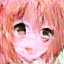

(0.006816969, 0.005555555555555556)


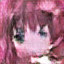

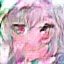

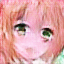

(0.0006526042, 0.0)


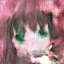

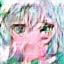

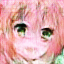

(0.0011021399, 0.002777777777777778)


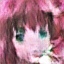

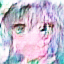

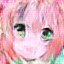

(0.0005715363, 0.0)


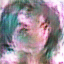

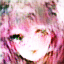

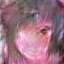

(2.3737006e-05, 0.0)


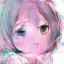

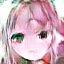

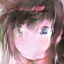

(0.0035557097, 0.002777777777777778)


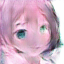

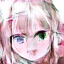

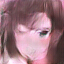

(0.004344408, 0.005555555555555556)


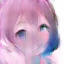

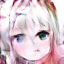

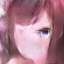

(0.010697133, 0.013888888888888888)


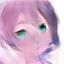

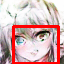

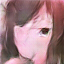

(0.03241426, 0.03333333333333333)


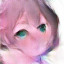

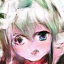

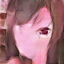

(0.018138243, 0.025)


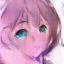

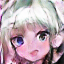

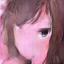

(0.009872128, 0.011111111111111112)


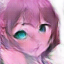

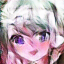

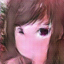

(0.011159565, 0.016666666666666666)


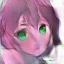

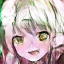

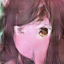

(0.009476713, 0.011111111111111112)


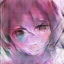

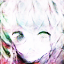

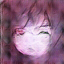

(8.574598e-07, 0.0)


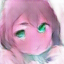

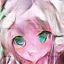

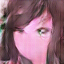

(0.00043123835, 0.0)


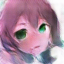

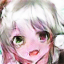

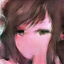

(0.013419679, 0.013888888888888888)


In [37]:
detection_model = Detector()

for model_name, generated_images_per_checkpoint in GENERATED_IMAGES.items():
    for check_point_num, generated_images in generated_images_per_checkpoint.items():
        # calculate ratio an anime face is detected
        transformed = []
        for image in generated_images:
            image = float_to_int(image)
            image = rgb_to_gbr(image)
            transformed.append(image)
        results = forward(detection_model, transformed)
        face_score = evaluate(transformed, results, 0.3)
        evaluation_results[model_name][check_point_num]['face_score'] = face_score[0]

## Results Visualization

notes that DCGAN's performance is better than WGAN. 
Both models peaked early, DCGAN at 50 - 75 epochs, WGAN at 100 epoch. 
There are mode collapse in DCGAN around 100 epoch. 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':


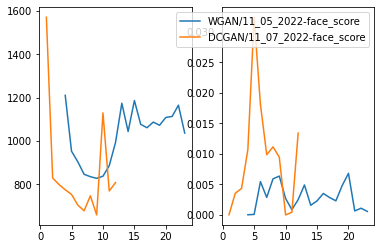

In [40]:
for test_name, results in evaluation_results.items(): 
    x = []
    fid_score = []
    face_score = []
    for checkpoint, metrics in results.items(): 
        x.append(checkpoint)
        fid_score.append(metrics['fid_score'])
        face_score.append(metrics['face_score'])
    plt.subplot(1, 2, 1)
    plt.plot(x, fid_score, label=f'{test_name}-fid_score')
    plt.subplot(1, 2, 2)
    plt.plot(x, face_score, label=f'{test_name}-face_score')
plt.legend()
plt.show()

## References
- [ Dataset](https://www.kaggle.com/datasets/soumikrakshit/anime-faces) from kaggle

- [FID](https://wandb.ai/ayush-thakur/gan-evaluation/reports/How-to-Evaluate-GANs-using-Frechet-Inception-Distance-FID---Vmlldzo0MTAxOTI)
